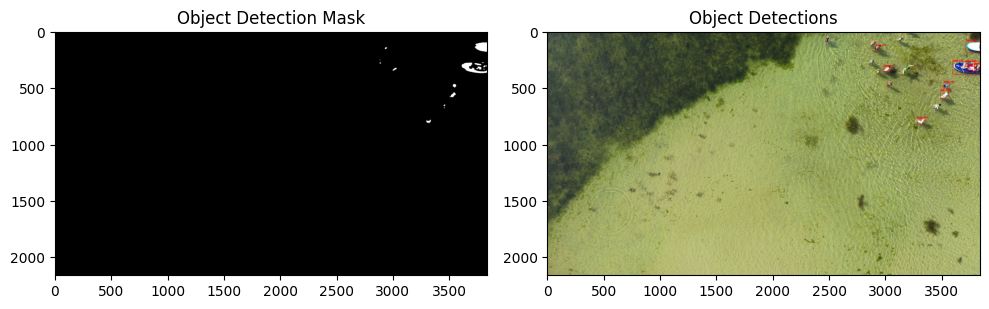

Results saved to object_detection_output1.jpg
Detected 7 objects

Object detections:
  Object 1: confidence 0.99, position: (3490, 532), size: 74x64
  Object 2: confidence 0.99, position: (3596, 270), size: 244x113
  Object 3: confidence 0.99, position: (3713, 90), size: 127x104
  Object 4: confidence 0.70, position: (3726, 304), size: 65x47
  Object 5: confidence 0.68, position: (3711, 274), size: 79x40
  Object 6: confidence 0.66, position: (3281, 775), size: 63x50
  Object 7: confidence 0.65, position: (3518, 458), size: 50x52


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


class AerialWaterObjectDetector:
    
    def __init__(self, debug_mode=False, confidence_threshold=0.5):
        self.debug_mode = debug_mode
        self.confidence_threshold = confidence_threshold
    
    def detect(self, image_path, output_path=None):
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")
        
        # Convert to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create a working copy for visualization
        visualization = image_rgb.copy()
        
        # Detect boats using their distinctive features
        object_detection = self._detect_objects(image_rgb)
        
        # Draw detections on the visualization image
        self._draw_detections(visualization, object_detection)
        
        # Save or display results
        if output_path:
            cv2.imwrite(output_path, cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))
            print(f"Results saved to {output_path}")
        elif self.debug_mode:
            plt.figure(figsize=(15, 10))
            plt.imshow(visualization)
            plt.title("Object Detections")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        
        return object_detection, visualization
    
    def _detect_objects(self, image):
        # Convert to HSV for color-based detection
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Step 1: Create color masks
        # White/light colored
        lower_white = np.array([0, 0, 180])
        upper_white = np.array([180, 30, 255])
        white_mask = cv2.inRange(hsv, lower_white, upper_white)
        
        lower_blue = np.array([90, 50, 50])
        upper_blue = np.array([130, 255, 255])
        blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
        
        # Combined mask
        boat_mask = cv2.bitwise_or(white_mask, blue_mask)
        
        # Clean up mask
        kernel = np.ones((5, 5), np.uint8)
        boat_mask = cv2.morphologyEx(boat_mask, cv2.MORPH_OPEN, kernel, iterations=1)
        boat_mask = cv2.morphologyEx(boat_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        # Step 2: Find contours in the mask
        contours, _ = cv2.findContours(boat_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Step 3: Filter contours based on size, shape, and area
        detected_objects = []
        
        for contour in contours:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            
            area = cv2.contourArea(contour)
                
            # Check if shape is appropriate for a boat
            if area > 200:
                # Add padding
                padding = 10
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(image.shape[1] - x, w + 2*padding)
                h = min(image.shape[0] - y, h + 2*padding)
                
                confidence = min(area / 1000, 0.99)
                detected_objects.append((x, y, w, h, confidence))
                
        
        # Step 4: If insufficient detections from color, try structural analysis
        if len(detected_objects) < 1:
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            
            # Enhance contrast
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(gray)
            
            # Use bilateral filter to preserve edges but smooth areas
            filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)
            
            # Use Canny edge detector to find edges
            edges = cv2.Canny(filtered, 30, 150)
            
            # Dilate to connect edges
            dilated = cv2.dilate(edges, kernel, iterations=1)
            
            # Find contours in the edges
            contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Filter contours
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                
                
            
                    
                aspect_ratio = float(w) / h
                area = cv2.contourArea(contour)
                
                # Boats typically have an aspect ratio between 1:1 and 3:1
                if 1.0 <= aspect_ratio <= 3.0 and area > 300:
                    # Add padding
                    padding = 10
                    x = max(0, x - padding)
                    y = max(0, y - padding)
                    w = min(image.shape[1] - x, w + 2*padding)
                    h = min(image.shape[0] - y, h + 2*padding)
                    
                    confidence = min(area / 2000, 0.7)  # Lower confidence for this method
                    detected_objects.append((x, y, w, h, confidence))
        
        # Step 5: Perform non-maximum suppression
        object_detections = self._non_max_suppression(detected_objects)
        # Filter by confidence threshold
        object_detections = [obj for obj in object_detections if obj[4] >= self.confidence_threshold]
        
        # Debug visualization if needed
        if self.debug_mode:
            debug_img = image.copy()
            for x, y, w, h, conf in detected_objects:
                cv2.rectangle(debug_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
                cv2.putText(debug_img, f"Object {conf:.2f}", (x, y-5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            plt.figure(figsize=(10, 8))
            plt.subplot(121)
            plt.imshow(boat_mask, cmap='gray')
            plt.title("Object Detection Mask")
            plt.subplot(122)
            plt.imshow(debug_img)
            plt.title("Object Detections")
            plt.tight_layout()
            plt.show()
        
        return object_detections
    
    def _non_max_suppression(self, boxes, overlap_threshold=0.3):
        """
        Apply non-maximum suppression to remove overlapping bounding boxes.
        
        Args:
            boxes: List of (x, y, w, h, confidence) tuples
            overlap_threshold: Maximum allowed overlap ratio
            
        Returns:
            list: Filtered bounding boxes
        """
        if not boxes:
            return []
        
        # Convert (x, y, w, h) to (x1, y1, x2, y2) format
        boxes_xyxy = [(x, y, x+w, y+h, conf) for x, y, w, h, conf in boxes]
        
        # Sort by confidence (highest first)
        boxes_xyxy.sort(key=lambda x: x[4], reverse=True)
        
        keep = []
        
        while boxes_xyxy:
            # Take the box with highest confidence
            current = boxes_xyxy.pop(0)
            keep.append(current)
            
            # Check remaining boxes
            i = 0
            while i < len(boxes_xyxy):
                # Calculate IoU between current box and this box
                iou = self._calculate_iou(current[:4], boxes_xyxy[i][:4])
                
                if iou > overlap_threshold:
                    # Remove box
                    boxes_xyxy.pop(i)
                else:
                    i += 1
        
        # Convert back to (x, y, w, h, confidence) format
        result = [(x1, y1, x2-x1, y2-y1, conf) for x1, y1, x2, y2, conf in keep]
        return result
    
    def _calculate_iou(self, box1, box2):
        """
        Calculate Intersection over Union for two boxes.
        
        Args:
            box1: Tuple of (x1, y1, x2, y2)
            box2: Tuple of (x1, y1, x2, y2)
            
        Returns:
            float: IoU value
        """
        # Calculate intersection area
        x_left = max(box1[0], box2[0])
        y_top = max(box1[1], box2[1])
        x_right = min(box1[2], box2[2])
        y_bottom = min(box1[3], box2[3])
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        
        # Calculate area of both boxes
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        
        # Calculate IoU
        iou = intersection_area / float(box1_area + box2_area - intersection_area)
        return iou
    
    def _draw_detections(self, image, boat_detections):
        
        # Draw object detections
        for i, (x, y, w, h, conf) in enumerate(boat_detections):
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Blue
            label = f"Object {conf:.2f}"
            cv2.putText(image, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


def detect_objects(image_path, output_path=None, debug_mode=False):
    # Initialize detector
    detector = AerialWaterObjectDetector(debug_mode=debug_mode)
    
    # Run detection
    objects, output = detector.detect(image_path, output_path)
    
    # Print summary
    print(f"Detected {len(objects)} objects")
    
    print("\nObject detections:")
    for i, (x, y, w, h, conf) in enumerate(objects):
        print(f"  Object {i+1}: confidence {conf:.2f}, position: ({x}, {y}), size: {w}x{h}")
    
    # Display the result if no output path is provided
    if not output_path:
        plt.figure(figsize=(15, 10))
        plt.imshow(output)
        plt.title("Object Detections")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return objects, output


# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = "dataset/working/images/val/a_101.jpg"
    
    # Run detection with debug mode on
    objects, _ = detect_objects(
        image_path,
        output_path="object_detection_output1.jpg",
        debug_mode=True
    )